# Deep Learning


## Assignment 1

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = './data/'

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 2% change in download progress
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 2 == 0:
            sys.stdout.write('%s%%' % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write('.')
            sys.stdout.flush()
        
        last_percent_reported = percent
    
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download: ', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload completed!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download:  notMNIST_large.tar.gz
0%.2%.4%.6%.8%.10%.12%.14%.16%.18%.20%.22%.24%.26%.28%.30%.32%.34%.36%.38%.40%.42%.44%.46%.48%.50%.52%.54%.56%.58%.60%.62%.64%.66%.68%.70%.72%.74%.76%.78%.80%.82%.84%.86%.88%.90%.92%.94%.96%.98%.100%
Download completed!
Found and verified ./data/notMNIST_large.tar.gz
Attempting to download:  notMNIST_small.tar.gz
0%.2%.4%.6%.8%.10%.12%.14%.16%.18%.20%.22%.24%.26%.28%.30%.32%.34%.36%.38%.40%.42%.44%.46%.48%.50%.52%.54%.56%.58%.60%.62%.64%.66%.68%.70%.72%.74%.76%.78%.80%.82%.84%.86%.88%.90%.92%.94%.96%.98%.100%
Download completed!
Found and verified ./data/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J

In [6]:
num_classes = 10
np.random.seed(13)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait. ' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))
    ]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected % folders, one per class. Found % instead' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for ./data/notMNIST_large. This may take a while. Please wait. 
['./data/notMNIST_large/A', './data/notMNIST_large/B', './data/notMNIST_large/C', './data/notMNIST_large/D', './data/notMNIST_large/E', './data/notMNIST_large/F', './data/notMNIST_large/G', './data/notMNIST_large/H', './data/notMNIST_large/I', './data/notMNIST_large/J']
Extracting data for ./data/notMNIST_small. This may take a while. Please wait. 
['./data/notMNIST_small/A', './data/notMNIST_small/B', './data/notMNIST_small/C', './data/notMNIST_small/D', './data/notMNIST_small/E', './data/notMNIST_small/F', './data/notMNIST_small/G', './data/notMNIST_small/H', './data/notMNIST_small/I', './data/notMNIST_small/J']


### Problem 1

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded.

In [14]:
for folder in train_folders:
    ex_file = os.listdir(folder)[5]
    ex_path = os.path.join(folder, ex_file)
    display(Image(filename=ex_path))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memeory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (iamge index, x, y) of floating point values, normalized to have aprroximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [19]:
image_size = 28
pixel_depth = 255.0

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) -
                          pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read: ', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected %d < %d' %
                        (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=True):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./data/notMNIST_large/A.pickle.
./data/notMNIST_large/A
Could not read:  ./data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read:  ./data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read:  ./data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling ./data/notMNIST_large/B.pickle.
./data/notMNIST_large/B
Could not read:  ./data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (529

### Problem 2

Let's verify that the data still looks good. Display a sample of the labels and images from the ndarray.

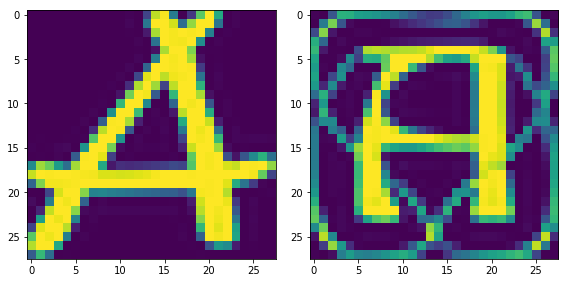

In [34]:
# Just sample arbitary image of 'A' from training set
sample_train_A = pickle.load(open(train_datasets[0], 'rb'))[100]

# Just sample arbitary image of 'A' from test set
sample_test_A = pickle.load(open(test_datasets[0], 'rb'))[100]

fig = plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(sample_train_A)
plt.subplot(122); plt.imshow(sample_test_A)
plt.tight_layout()
plt.show()

### Problem 3

Another check: we expect the data to be balanced across classes. Verify that

In [47]:
# Create a dictionaries whose keys are the letters and values are the number
# of training samples of that letters 
train_samples = { item[-8]: len(pickle.load(open(item,'rb'))) for item in train_datasets}
test_samples = { item[-8]: len(pickle.load(open(item,'rb'))) for item in test_datasets}

{'A': 1872,
 'B': 1873,
 'C': 1873,
 'D': 1873,
 'E': 1873,
 'F': 1872,
 'G': 1872,
 'H': 1872,
 'I': 1872,
 'J': 1872}

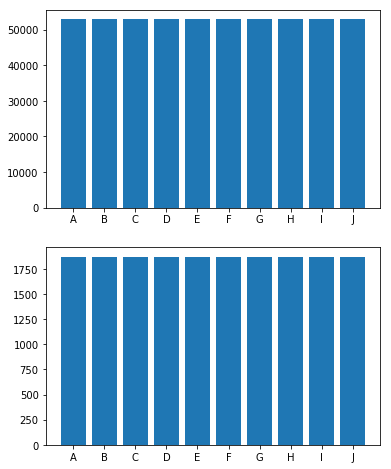

In [51]:
def plot_hist(data_dict, fig_no, title, num_cols=2, num_rows=1):
    """Plot the histogram from an input dictionary"""
    plt.subplot(num_cols, num_rows, fig_no)
    plt.bar(range(len(data_dict)), data_dict.values(), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.title()

fig = plt.figure(figsize=(6, 8))

plot_hist(train_samples, 1)
plot_hist(test_samples, 2)

plt.show()